This notebook investigates to what extent "clouds" close the budget for certain relevant variables such as liquid water, mass flux etc. "Clouds" are decomposed with two different thresholds: initially simply by considering all points containing liquid water and then a threshold which includes both liquid water and vertical velocity (updraft). 

The idea is is similar to the work done by Siebesma & Cuijpers (1994) who discovered that "estimates of turbulent fluxes by bulk cloud updrafts and environmental downdrafts give an underestimation of 20% to 50% depending on the variable that is transported" 

Here, I use the data from the RICO simulation to calculate the total variable and then compare it to the result from the cloudtracking algorithm, initally for liquid water. 

Check mass flux first and then dive into the rest as specified by Siebesma & Cuijpers (1994).

# Mass flux


Mass flux
$$
    \phi_m = \rho w A
$$

Density
$$
\rho = \frac{p_d}{R_d T} + \frac{p_v}{R_v T} + q_l \rho_l,
$$

Partial pressures
$$
p_v = \frac{q_v}{q_v + \epsilon} p
$$

Temperature
$$
    T \approx \theta_l\Big(\frac{c_{pd}}{c_{pd} - L_v q_l}\Big)\Big(\frac{p_0}{p}\Big)^{-\kappa}
$$

In [45]:
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapour
L_v = 2268000.0  # J/kg latent heat of vaporisation
p_0 = 100000.0  # Pa standard pressure at sea level
rho_l = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
horizontal_resolution = 25.0
liquid_water_threshold = 0.000001
vertical_velocity_threshold = 0.0


def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    p_v = (q_v / (q_v + epsilon)) * p
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_l)
    return rho

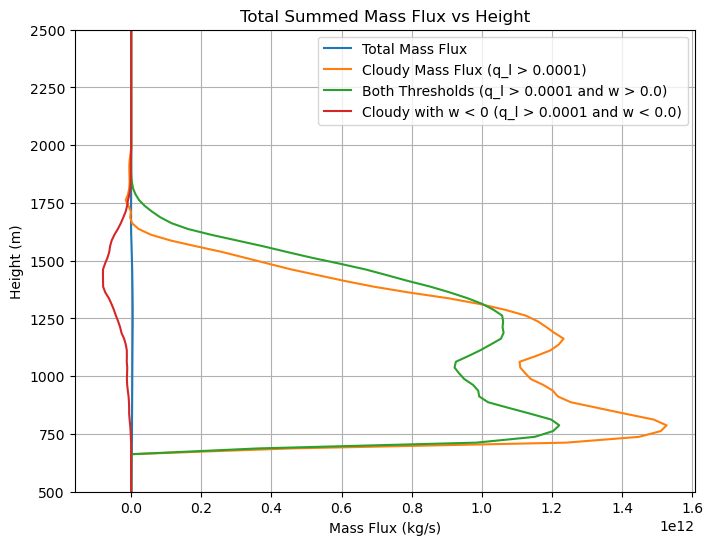

In [62]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Constants
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapour
L_v = 2268000.0  # J/kg latent heat of vaporisation
p_0 = 100000.0  # Pa standard pressure at sea level
rho_l = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
horizontal_resolution = 25.0  # in meters

# Thresholds
liquid_water_threshold = 0.0001
vertical_velocity_threshold = 0.0

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    p_v = (q_v / (q_v + epsilon)) * p
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_l)
    return rho

def calculate_mass_flux_and_density(timestep):
    zt_values = load_zt_values(l_file)
    with nc.Dataset(w_file) as ds:
        y_dim, x_dim = ds.dimensions['yt'].size, ds.dimensions['xt'].size

    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    p_data = load_data_all_levels(p_file, 'p', timestep)
    q_data = load_data_all_levels(q_file, 'q', timestep)
    t_data = load_data_all_levels(t_file, 't', timestep)
    
    T = calculate_temperature(t_data, p_data, q_data / 1000, l_data / 1000, (q_data - l_data) / 1000)
    rho = calculate_density(T, p_data, l_data / 1000, (q_data - l_data) / 1000)
    mass_flux = w_data * rho * horizontal_resolution ** 2
    
    return mass_flux, rho, zt_values, y_dim, x_dim

# Specify the timestep to analyze
specified_timestep = 20

# Calculate mass flux and density for the specified timestep
mass_flux, rho, zt_values, y_dim, x_dim = calculate_mass_flux_and_density(specified_timestep)
l_data = load_data_all_levels(l_file, 'l', specified_timestep)
w_data = load_data_all_levels(w_file, 'w', specified_timestep)

# Calculate the mass flux for the entire field, cloudy areas, both thresholds, and areas with w < 0
mass_flux_total = mass_flux
mass_flux_cloudy = np.where(l_data > liquid_water_threshold, mass_flux, 0)
mass_flux_both = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), mass_flux, 0)
mass_flux_w_neg = np.where((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold), mass_flux, 0)

# Calculate the areas
total_area = y_dim * x_dim 
cloudy_area = np.count_nonzero(l_data > liquid_water_threshold) 
both_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold))
w_neg_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold))

# Scale the mass flux by the areas
scaled_mass_flux_total = np.sum(mass_flux_total, axis=(1, 2)) * total_area
scaled_mass_flux_cloudy = np.sum(mass_flux_cloudy, axis=(1, 2)) * cloudy_area
scaled_mass_flux_both = np.sum(mass_flux_both, axis=(1, 2)) * both_area
scaled_mass_flux_w_neg = np.sum(mass_flux_w_neg, axis=(1, 2)) * w_neg_area

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(scaled_mass_flux_total, zt_values, label='Total Mass Flux')
ax.plot(scaled_mass_flux_cloudy, zt_values, label=f'Cloudy Mass Flux (q_l > {liquid_water_threshold})')
ax.plot(scaled_mass_flux_both, zt_values, label=f'Both Thresholds (q_l > {liquid_water_threshold} and w > {vertical_velocity_threshold})')
ax.plot(scaled_mass_flux_w_neg, zt_values, label=f'Cloudy with w < 0 (q_l > {liquid_water_threshold} and w < {vertical_velocity_threshold})')

ax.set_xlabel('Mass Flux (kg/s)')
ax.set_ylabel('Height (m)')
ax.set_title('Total Summed Mass Flux vs Height')
ax.grid(True)
#ax.set_xscale('log')
ax.set_ylim([500, 2500])
ax.legend()
plt.show()


**Total mass flux summed over all active points**. Active refers to the point that are above the threshold. Total mass flux is very small compared to other two as it involves both positive and negative contributions!


To find about about the absolute amounts of flux, the next plot shows the absolute values of mass flux added together: so even negative flux (downward facing) is added. 

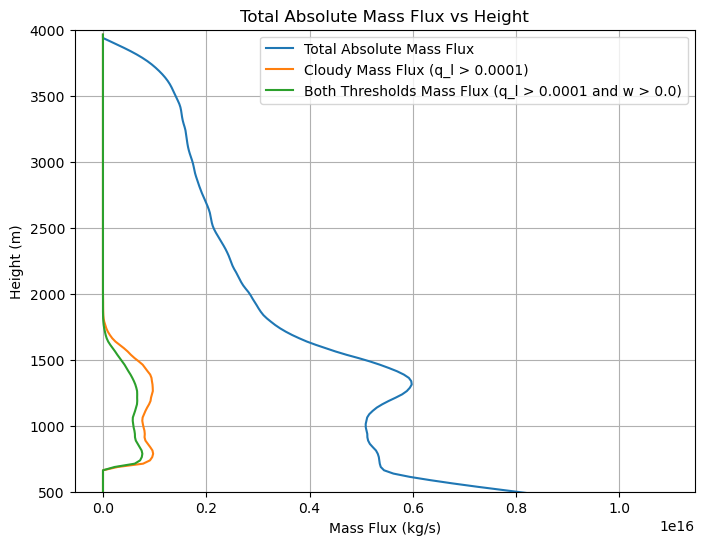

In [63]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

def calculate_mass_flux_and_density(timestep):
    zt_values = load_zt_values(l_file)
    with nc.Dataset(w_file) as ds:
        y_dim, x_dim = ds.dimensions['yt'].size, ds.dimensions['xt'].size

    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    p_data = load_data_all_levels(p_file, 'p', timestep)
    q_data = load_data_all_levels(q_file, 'q', timestep)
    t_data = load_data_all_levels(t_file, 't', timestep)
    
    T = calculate_temperature(t_data, p_data, q_data / 1000, l_data / 1000, (q_data - l_data) / 1000)
    rho = calculate_density(T, p_data, l_data / 1000, (q_data - l_data) / 1000)
    mass_flux = w_data * rho * horizontal_resolution ** 2
    
    return np.abs(mass_flux), rho, zt_values, y_dim, x_dim

# Specify the timestep to analyze
specified_timestep = 20  # Change this to the desired timestep

# Calculate mass flux and density for the specified timestep
mass_flux, rho, zt_values, y_dim, x_dim = calculate_mass_flux_and_density(specified_timestep)
l_data = load_data_all_levels(l_file, 'l', specified_timestep)
w_data = load_data_all_levels(w_file, 'w', specified_timestep)

# Calculate the mass flux for the entire field, cloudy areas, and both thresholds
mass_flux_total = mass_flux
mass_flux_cloudy = np.where(l_data > liquid_water_threshold, mass_flux, 0)
mass_flux_both = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), mass_flux, 0)

# Calculate the areas
total_area = y_dim * x_dim * horizontal_resolution ** 2
cloudy_area = np.count_nonzero(l_data > liquid_water_threshold) * horizontal_resolution ** 2
both_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold)) * horizontal_resolution ** 2

# Scale the mass flux by the areas
scaled_mass_flux_total = np.sum(mass_flux_total, axis=(1, 2)) * total_area
scaled_mass_flux_cloudy = np.sum(mass_flux_cloudy, axis=(1, 2)) * cloudy_area
scaled_mass_flux_both = np.sum(mass_flux_both, axis=(1, 2)) * both_area

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(scaled_mass_flux_total, zt_values, label='Total Absolute Mass Flux')
ax.plot(scaled_mass_flux_cloudy, zt_values, label=f'Cloudy Mass Flux (q_l > {liquid_water_threshold})')
ax.plot(scaled_mass_flux_both, zt_values, label=f'Both Thresholds Mass Flux (q_l > {liquid_water_threshold} and w > {vertical_velocity_threshold})')

ax.set_xlabel('Mass Flux (kg/s)')
ax.set_ylabel('Height (m)')
ax.set_title('Total Absolute Mass Flux vs Height')
ax.grid(True)
ax.set_ylim([500, 4000])
ax.legend()

plt.show()


## Average over first X minutes

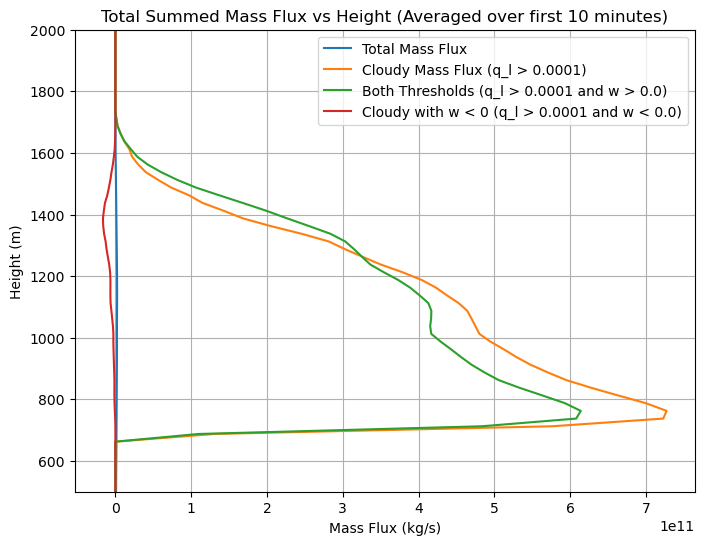

In [64]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'

# Averaging over the first specified number of minutes
def average_mass_flux_over_minutes(minutes):
    timesteps = minutes // 4  # Assuming each timestep is 4 minutes

    mass_flux_total = None
    mass_flux_cloudy = None
    mass_flux_both = None
    mass_flux_w_neg = None

    for timestep in range(timesteps):
        mass_flux, rho, zt_values, y_dim, x_dim = calculate_mass_flux_and_density(timestep)
        l_data = load_data_all_levels(l_file, 'l', timestep)
        w_data = load_data_all_levels(w_file, 'w', timestep)
        
        if mass_flux_total is None:
            mass_flux_total = mass_flux
            mass_flux_cloudy = np.where(l_data > liquid_water_threshold, mass_flux, 0)
            mass_flux_both = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), mass_flux, 0)
            mass_flux_w_neg = np.where((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold), mass_flux, 0)
        else:
            mass_flux_total += mass_flux
            mass_flux_cloudy += np.where(l_data > liquid_water_threshold, mass_flux, 0)
            mass_flux_both += np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), mass_flux, 0)
            mass_flux_w_neg += np.where((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold), mass_flux, 0)

    mass_flux_total /= timesteps
    mass_flux_cloudy /= timesteps
    mass_flux_both /= timesteps
    mass_flux_w_neg /= timesteps

    total_area = y_dim * x_dim 
    cloudy_area = np.count_nonzero(l_data > liquid_water_threshold) 
    both_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold))
    w_neg_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold))

    scaled_mass_flux_total = np.sum(mass_flux_total, axis=(1, 2)) * total_area
    scaled_mass_flux_cloudy = np.sum(mass_flux_cloudy, axis=(1, 2)) * cloudy_area
    scaled_mass_flux_both = np.sum(mass_flux_both, axis=(1, 2)) * both_area
    scaled_mass_flux_w_neg = np.sum(mass_flux_w_neg, axis=(1, 2)) * w_neg_area

    return scaled_mass_flux_total, scaled_mass_flux_cloudy, scaled_mass_flux_both, scaled_mass_flux_w_neg, zt_values

# Specify the number of minutes to average over
average_minutes = 10

scaled_mass_flux_total, scaled_mass_flux_cloudy, scaled_mass_flux_both, scaled_mass_flux_w_neg, zt_values = average_mass_flux_over_minutes(average_minutes)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(scaled_mass_flux_total, zt_values, label='Total Mass Flux')
ax.plot(scaled_mass_flux_cloudy, zt_values, label=f'Cloudy Mass Flux (q_l > {liquid_water_threshold})')
ax.plot(scaled_mass_flux_both, zt_values, label=f'Both Thresholds (q_l > {liquid_water_threshold} and w > {vertical_velocity_threshold})')
ax.plot(scaled_mass_flux_w_neg, zt_values, label=f'Cloudy with w < 0 (q_l > {liquid_water_threshold} and w < {vertical_velocity_threshold})')
ax.set_xlabel('Mass Flux (kg/s)')
ax.set_ylabel('Height (m)')
ax.set_title(f'Total Summed Mass Flux vs Height (Averaged over first {average_minutes} minutes)')
ax.grid(True)
ax.set_ylim([500, 2000])
ax.legend()
plt.show()


# Liquid water "flux"

Defined simply as $w*q_l$, the horizontal level average of both. 

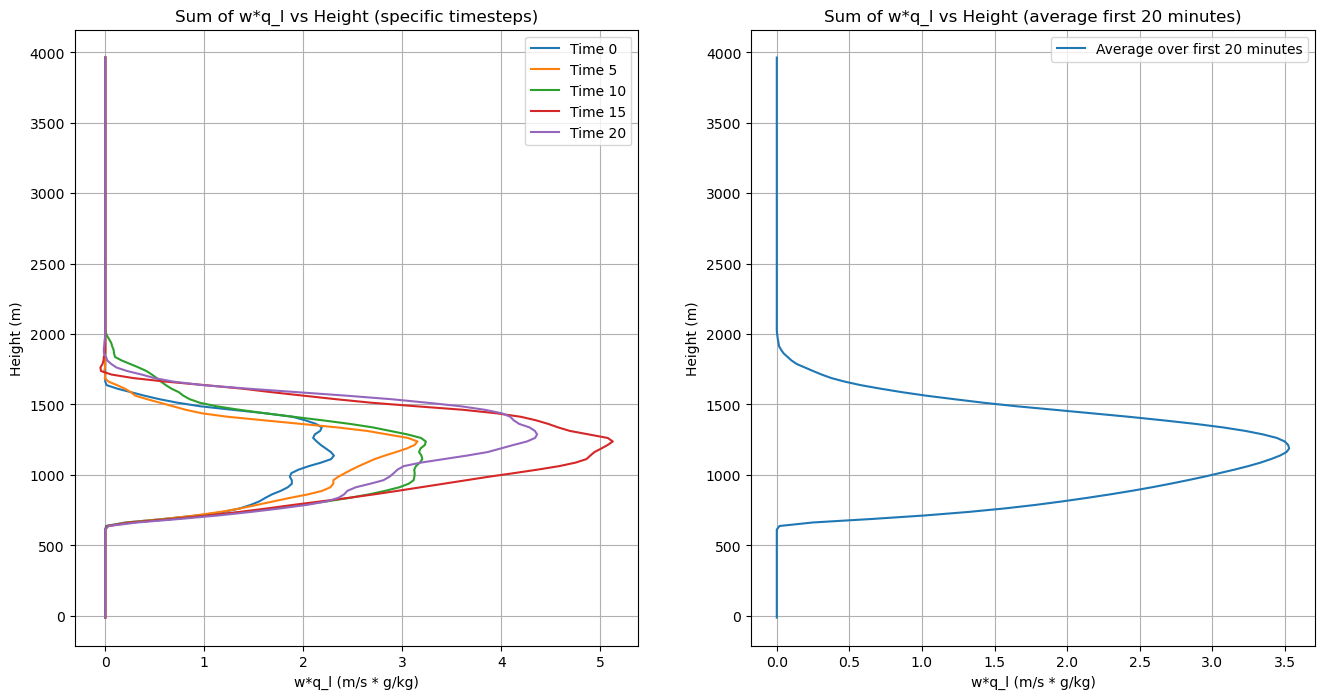

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

# Load zt values from the liquid water file
zt_values = load_zt_values(l_file)

timesteps = [0, 5, 10,15, 20]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot for specific timesteps
for timestep in timesteps:
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    product_data = w_data * l_data
    product_means = np.sum(product_data, axis=(1, 2))  # Sum over both horizontal dimensions
    
    axs[0].plot(product_means, zt_values, label=f'Time {timestep}')

axs[0].set_xlabel('w*q_l (m/s * g/kg)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Sum of w*q_l vs Height (specific timesteps)')
axs[0].grid(True)
axs[0].legend()

# Averaging over the first 20 minutes
end_timestep = 20
sum_product_data = None

for timestep in range(end_timestep):
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    product_data = w_data * l_data
    if sum_product_data is None:
        sum_product_data = product_data
    else:
        sum_product_data += product_data

average_product_data = sum_product_data / end_timestep
average_product_means = np.sum(average_product_data, axis=(1, 2))

axs[1].plot(average_product_means, zt_values, label='Average over first 20 minutes')
axs[1].set_xlabel('w*q_l (m/s * g/kg)')
axs[1].set_ylabel('Height (m)')
axs[1].set_title('Sum of w*q_l vs Height (average first 20 minutes)')
axs[1].grid(True)
axs[1].legend()

Decomposing the field into cloudy and environment areas to estimate how much of the total "flux" is captured by clouds.
1. Total field average (no cloud threshold)
2. Cloudy part threshold: liquid water
3. Cloudy part threshold: liquid water + updraft (positive vertical velocity). 

In [2]:
# Paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

# Thresholds
liquid_water_threshold = 0.0001
vertical_velocity_threshold = 0.0

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

In [3]:
# Load zt values from the liquid water file
zt_values = load_zt_values(l_file)

# Averaging over the first 20 minutes
end_timestep = 20
sum_product_data = None
sum_product_data_l_threshold = None
sum_product_data_wl_threshold = None

for timestep in range(end_timestep):
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    product_data = w_data * l_data
    product_data_l_threshold = np.where(l_data > liquid_water_threshold, w_data * l_data, 0)
    product_data_wl_threshold = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), w_data * l_data, 0)

    if sum_product_data is None:
        sum_product_data = product_data
        sum_product_data_l_threshold = product_data_l_threshold
        sum_product_data_wl_threshold = product_data_wl_threshold
    else:
        sum_product_data += product_data
        sum_product_data_l_threshold += product_data_l_threshold
        sum_product_data_wl_threshold += product_data_wl_threshold

average_product_data = sum_product_data / end_timestep
average_product_means = np.sum(average_product_data, axis=(1, 2))

average_product_data_l_threshold = sum_product_data_l_threshold / end_timestep
average_product_means_l_threshold = np.sum(average_product_data_l_threshold, axis=(1, 2))

average_product_data_wl_threshold = sum_product_data_wl_threshold / end_timestep
average_product_means_wl_threshold = np.sum(average_product_data_wl_threshold, axis=(1, 2))


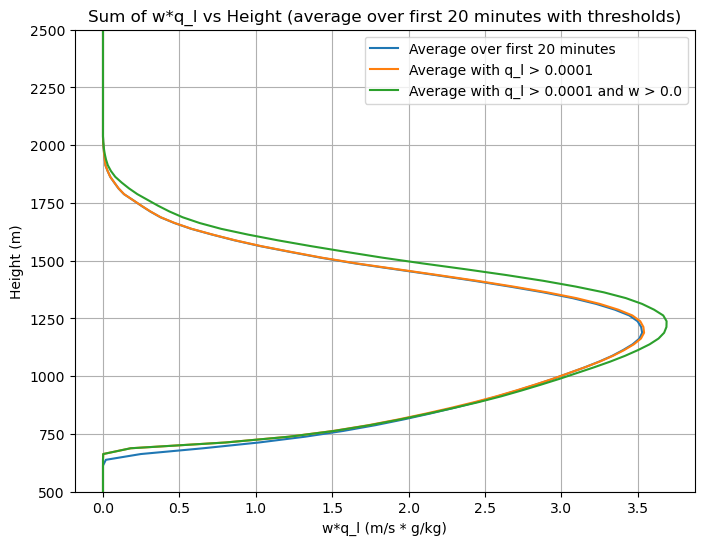

In [4]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(average_product_means, zt_values, label='Average over first 20 minutes')
ax.plot(average_product_means_l_threshold, zt_values, label=f'Average with q_l > {liquid_water_threshold}')
ax.plot(average_product_means_wl_threshold, zt_values, label=f'Average with q_l > {liquid_water_threshold} and w > {vertical_velocity_threshold}')

ax.set_xlabel('w*q_l (m/s * g/kg)')
ax.set_ylabel('Height (m)')
ax.set_title('Sum of w*q_l vs Height (average over first 20 minutes with thresholds)')
ax.set_ylim([500,2500])
ax.grid(True)
ax.legend()
plt.show()

# Turbulent flux
## Disambiguation of the definitions

Deciding on how to best calculate $\big(\overline{w'\phi'}\big)$. Siebesma uses: 

$$\large \big(\overline{w'\phi'}\big) = a {\overline{w'\phi'}}^c  + (1-a) {\overline{w'\phi'}}^e + a(1-a)(w_c-w_e)(\phi_c-\phi_e)$$

where $a$ is the fraction of the active cloud park and $c$ and $e$ denote active cloud and passive environmental averages. The overbar denotes the average over the horizontal level of the model and prime denotes the deviation from the horizontal level average.

Siebesma continues that in mass flux parameterisation schemes, it is assumed that organised turbulence term is dominant, so that

$$\large \big(\overline{w'\phi'}\big) = a(1-a)(w_c-w_e)(\phi_c-\phi_e = \frac{M}{\rho}(\phi_c - \phi_e)$$

where $M$ is defined as a convective mass transport and $\rho$ is density. 





## Turbulent flux: Fractional coverage definition

Using this definition to start: 
$$\large \big(\overline{w'\phi'}\big) = a(1-a)(w_c-w_e)(\phi_c-\phi_e)$$

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


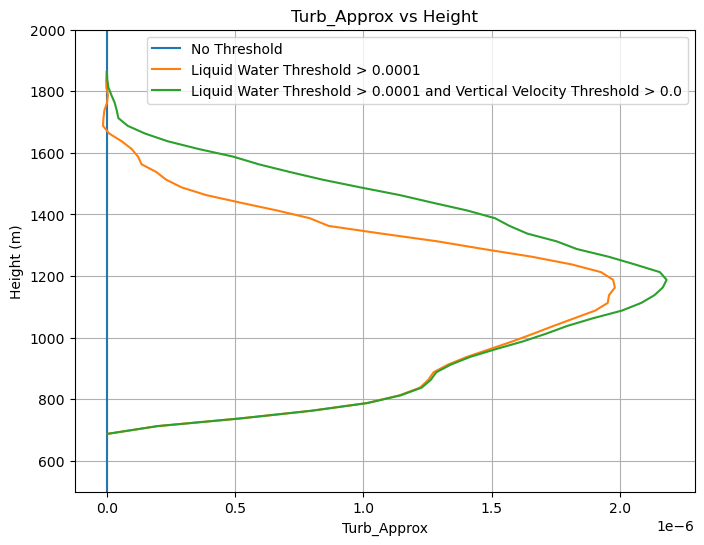

In [5]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

# Thresholds
liquid_water_threshold = 0.0001
vertical_velocity_threshold = 0.0

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

# Load zt values from the liquid water file
zt_values = load_zt_values(l_file)

# Averaging over the first 20 minutes
end_timestep = 5
w_sum_data = None
l_sum_data = None
cloudy_points = None
non_cloudy_points = None

for timestep in range(end_timestep):
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    if w_sum_data is None:
        w_sum_data = w_data
        l_sum_data = l_data
        cloudy_points = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), 1, 0)
        non_cloudy_points = np.where((l_data <= liquid_water_threshold) | (w_data <= vertical_velocity_threshold), 1, 0)
    else:
        w_sum_data += w_data
        l_sum_data += l_data
        cloudy_points += np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), 1, 0)
        non_cloudy_points += np.where((l_data <= liquid_water_threshold) | (w_data <= vertical_velocity_threshold), 1, 0)

average_w_data = w_sum_data / end_timestep
average_l_data = l_sum_data / end_timestep
fraction_cloudy = cloudy_points / end_timestep

turb_approx_no_threshold = []
turb_approx_liquid_threshold = []
turb_approx_both_thresholds = []

for z in range(average_w_data.shape[0]):
    w_mean = np.mean(average_w_data[z, :, :])
    q_mean = np.mean(average_l_data[z, :, :])
    
    mask_cloudy = (average_l_data[z, :, :] > liquid_water_threshold)
    mask_both = (average_l_data[z, :, :] > liquid_water_threshold) & (average_w_data[z, :, :] > vertical_velocity_threshold)
    
    w_c = np.mean(average_w_data[z, :, :][mask_cloudy])
    w_e = np.mean(average_w_data[z, :, :][~mask_cloudy])
    q_c = np.mean(average_l_data[z, :, :][mask_cloudy])
    q_e = np.mean(average_l_data[z, :, :][~mask_cloudy])
    a = np.mean(mask_cloudy)
    turb_approx_liquid_threshold.append(a * (1 - a) * (w_c - w_e) * (q_c - q_e))
    
    w_c_both = np.mean(average_w_data[z, :, :][mask_both])
    w_e_both = np.mean(average_w_data[z, :, :][~mask_both])
    q_c_both = np.mean(average_l_data[z, :, :][mask_both])
    q_e_both = np.mean(average_l_data[z, :, :][~mask_both])
    a_both = np.mean(mask_both)
    turb_approx_both_thresholds.append(a_both * (1 - a_both) * (w_c_both - w_e_both) * (q_c_both - q_e_both))
    
    turb_approx_no_threshold.append(w_mean * q_mean)  # Calculation for no threshold

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(turb_approx_no_threshold, zt_values, label='No Threshold')
ax.plot(turb_approx_liquid_threshold, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold}')
ax.plot(turb_approx_both_thresholds, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold} and Vertical Velocity Threshold > {vertical_velocity_threshold}')

ax.set_xlabel('Turb_Approx')
ax.set_ylabel('Height (m)')
ax.set_title('Turb_Approx vs Height')
ax.grid(True)
ax.set_ylim([500,2000])
ax.legend()


## Turbulent flux: mass flux definition
Using the definition that includes mass flux

$$\large \big(\overline{w'\phi'}\big) =  \frac{M}{\rho}(\phi_c - \phi_e)$$

requires the calculation of mass flux. 

### Questions/issues
- Is it calculated per unit area? If so, how do you define area when $(\phi_c - \phi_e)$?
- Is $M$ taken as the field mean? total field sum? is it in absolute terms? Since it's both positive and negative.
- How to calculate total $\big(\overline{w'\phi'}\big)$ with no thresholds?
- Why are the units the same no matter the variable (in the paper)?


### Step 1: calculating mass flux
From the output fields in the current RICO LES run which includes variables $q_l, \theta_l, p, w, $, mass flux can be reconstructed by first calculating the in-situ temperature, from which density can be calculated, which then finally gives mass flux.

In [6]:
import numpy as np
import netCDF4 as nc
import os

R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapour
L_v = 2268000.0  # J/kg latent heat of vaporisation
p_0 = 100000.0  # Pa standard pressure at sea level
rho_l = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
horizontal_resolution = 25.0

w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'


def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    # Calculate kappa for each point
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    # Calculate temperature
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    # Partial pressure of vapor
    p_v = (q_v / (q_v + epsilon)) * p
    # Calculate density
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_l)
    return rho

# Function to calculate mass flux and density for a given timestep
def calculate_mass_flux_and_density(timestep):
    zt_values = load_zt_values(l_file)
    with nc.Dataset(w_file) as ds:
        y_dim, x_dim = ds.dimensions['yt'].size, ds.dimensions['xt'].size

    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    p_data = load_data_all_levels(p_file, 'p', timestep)
    q_data = load_data_all_levels(q_file, 'q', timestep)
    t_data = load_data_all_levels(t_file, 't', timestep)
    
    # Calculate temperature
    T = calculate_temperature(t_data, p_data, q_data/1000, l_data/1000, (q_data - l_data)/1000)
    
    # Calculate density
    rho = calculate_density(T, p_data, l_data/1000, (q_data - l_data)/1000)
    
    # Calculate mass flux
    mass_flux = w_data * rho * horizontal_resolution ** 2
    
    return mass_flux, rho, zt_values, y_dim, x_dim


In [7]:
# Choose a specific timestep
chosen_timestep = 7  # Set the desired timestep here

# Calculate mass flux and density for the chosen timestep
mass_flux, rho, zt_values, y_dim, x_dim = calculate_mass_flux_and_density(chosen_timestep)

# Save mass flux field to a new NetCDF file
mass_flux_output_file = f'/Users/jure/PhD/coding/RICO_1hr/rico.mass_flux_timestep_{chosen_timestep}.nc'
with nc.Dataset(mass_flux_output_file, 'w', format='NETCDF4') as ds_out:
    # Create dimensions
    ds_out.createDimension('time', 1)
    ds_out.createDimension('zt', len(zt_values))
    ds_out.createDimension('yt', y_dim)
    ds_out.createDimension('xt', x_dim)
    
    # Create variables
    time_var = ds_out.createVariable('time', 'f4', ('time',))
    zt_var = ds_out.createVariable('zt', 'f4', ('zt',))
    yt_var = ds_out.createVariable('yt', 'f4', ('yt',))
    xt_var = ds_out.createVariable('xt', 'f4', ('xt',))
    mass_flux_var = ds_out.createVariable('mass_flux', 'f4', ('time', 'zt', 'yt', 'xt',))
    
    # Write data to variables
    time_var[:] = [chosen_timestep]
    zt_var[:] = zt_values
    yt_var[:] = np.arange(y_dim)
    xt_var[:] = np.arange(x_dim)
    mass_flux_var[0, :, :, :] = mass_flux

print(f"Mass flux calculation for timestep {chosen_timestep} completed and saved to NetCDF.")

# Save density field to a new NetCDF file
density_output_file = f'/Users/jure/PhD/coding/RICO_1hr/rico.density_timestep_{chosen_timestep}.nc'
with nc.Dataset(density_output_file, 'w', format='NETCDF4') as ds_out:
    # Create dimensions
    ds_out.createDimension('time', 1)
    ds_out.createDimension('zt', len(zt_values))
    ds_out.createDimension('yt', y_dim)
    ds_out.createDimension('xt', x_dim)
    
    # Create variables
    time_var = ds_out.createVariable('time', 'f4', ('time',))
    zt_var = ds_out.createVariable('zt', 'f4', ('zt',))
    yt_var = ds_out.createVariable('yt', 'f4', ('yt',))
    xt_var = ds_out.createVariable('xt', 'f4', ('xt',))
    density_var = ds_out.createVariable('density', 'f4', ('time', 'zt', 'yt', 'xt',))
    
    # Write data to variables
    time_var[:] = [chosen_timestep]
    zt_var[:] = zt_values
    yt_var[:] = np.arange(y_dim)
    xt_var[:] = np.arange(x_dim)
    density_var[0, :, :, :] = rho

print(f"Density calculation for timestep {chosen_timestep} completed and saved to NetCDF.")

Mass flux calculation for timestep 7 completed and saved to NetCDF.
Density calculation for timestep 7 completed and saved to NetCDF.


/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:5329: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


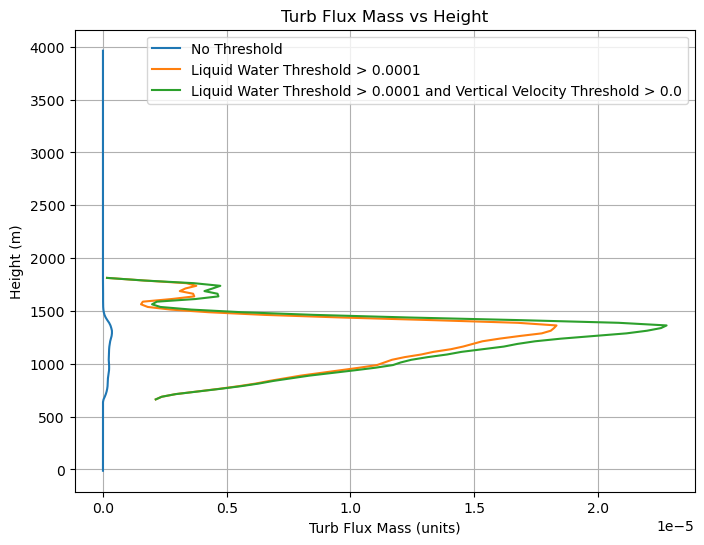

In [8]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Specify the chosen timestep
chosen_timestep = 6  # Set this to the desired timestep

# Paths to the NetCDF files
mass_flux_file = f'/Users/jure/PhD/coding/RICO_1hr/rico.mass_flux_timestep_{chosen_timestep}.nc'
density_file = f'/Users/jure/PhD/coding/RICO_1hr/rico.density_timestep_{chosen_timestep}.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'

# Thresholds
liquid_water_threshold = 0.0001
vertical_velocity_threshold = 0.0

def load_data_from_file(filename, var_name):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][:]
    return data

# Load data from NetCDF files
mass_flux = load_data_from_file(mass_flux_file, 'mass_flux')[0]  # Assuming time dimension is first
rho = load_data_from_file(density_file, 'density')[0]
zt_values = load_data_from_file(l_file, 'zt')
l_data = load_data_from_file(l_file, 'l')[chosen_timestep]
w_data = load_data_from_file(w_file, 'w')[chosen_timestep]

# Initialize arrays for turb_flux_mass
turb_flux_mass_no_threshold = np.zeros(len(zt_values))
turb_flux_mass_liquid_threshold = np.zeros(len(zt_values))
turb_flux_mass_both_thresholds = np.zeros(len(zt_values))

# Calculate turb_flux_mass for each height level
for z in range(len(zt_values)):
    mask_cloudy = (l_data[z, :, :] > liquid_water_threshold)
    mask_both = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > vertical_velocity_threshold)
    
    q_l_c = np.mean(l_data[z, :, :][mask_cloudy])
    q_l_e = np.mean(l_data[z, :, :][~mask_cloudy])
    
    q_l_c_both = np.mean(l_data[z, :, :][mask_both])
    q_l_e_both = np.mean(l_data[z, :, :][~mask_both])
    
    M = np.mean(mass_flux[z, :, :])
    rho_mean = np.mean(rho[z, :, :])
    
    # For the no-threshold case, use the q_l values directly
    turb_flux_mass_no_threshold[z] = M / rho_mean * np.mean(l_data[z, :, :])
    turb_flux_mass_liquid_threshold[z] = M / rho_mean * (q_l_c - q_l_e)
    turb_flux_mass_both_thresholds[z] = M / rho_mean * (q_l_c_both - q_l_e_both)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(turb_flux_mass_no_threshold, zt_values, label='No Threshold')
ax.plot(turb_flux_mass_liquid_threshold, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold}')
ax.plot(turb_flux_mass_both_thresholds, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold} and Vertical Velocity Threshold > {vertical_velocity_threshold}')
ax.set_xlabel('Turb Flux Mass (units)')
ax.set_ylabel('Height (m)')
ax.set_title('Turb Flux Mass vs Height')
ax.grid(True)
ax.legend()


This probably shouldn't look like this. What have I dont to check if this is doing the right thing
1. Equations calculating mass flux, temperature density: they seem correct. 
2. The rho data also seems correctly calculated (Shape of the density dataset: (160, 512, 512)), gradually dropping from 1.2 at sea level to 0.8 at 4000m. 
3. Mass flux is negative: need to understand why! **Fixed**: water species ratios were not in the correct units (had to be divided by 1000). 

just multiply it with the actual value of the variable (in this case q_l (rather than (q_l_c - q_l_e)))

calculate the mss trqndport at ever single point. then you take the average over cloudy points and then you mutlpliy it with the number of cloudy points. ?